# Face Detection and Recognition using MTCNN and InceptionResNetV1

In [4]:
import os
import re

import random
import numpy as np
import pandas as pd

from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from facenet_pytorch import InceptionResnetV1

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from src import detect_faces, show_bboxes

## Extracting and saving faces from the given images

In [ ]:
def extract_and_save_faces(image, bounding_boxes, output_folder, start_face_count):
    current_face_count = start_face_count

    for (x1, y1, x2, y2) in bounding_boxes:
        if x1>=20 and y1>=20:
            face_image = image.crop((x1-15, y1-15, x2+15, y2+15))
        else:
            face_image = image.crop((x1, y1, x2+15, y2+15))

        output_path = os.path.join(output_folder, )
        face_image.save(output_folder+f'face_{current_face_count}.png')

        current_face_count += 1

    return current_face_count

input_folder = 'Dataset/Images/'
output_folder = 'Dataset/Faces/Images/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

start_face_count = 1

files = os.listdir(input_folder)

for filename in files:
    if filename.endswith(".png"):
        image = Image.open(input_folder+filename)

        bounding_boxes, _ = detect_faces(image)
        bounding_boxes = bounding_boxes[bounding_boxes[:,4]>0.98]
        bounding_boxes = np.array(bounding_boxes[:,:4], dtype=np.int16)

        start_face_count = extract_and_save_faces(image, bounding_boxes, output_folder, start_face_count)

print(f'Faces extracted from all images and saved in the "{output_folder}" folder.')

c:\Users\bhanu\OneDrive\Desktop\UNH\Deep learning\mtcnn-pytorch-master\Face-Detection\src\get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
c:\Users\bhanu\OneDrive\Desktop\UNH\Deep learning\mtcnn-pytorch-master\Face-Detection\src\get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
c:\Users\bhanu\OneDrive\Desktop\UNH\Deep learning\mtcnn-pytorch-master\Face-Detection\src\get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


Faces extracted from all images and saved in the "faces/" folder.


## Custom PyTorch Faces Dataset

In [17]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

class FacesDataset(Dataset):
    def __init__(self, data_folder, file_names, labels, transform=None):
        self.data_folder = data_folder
        self.transform = transform

        self.file_names = file_names
        self.num_labels = labels

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image_path = self.file_names[index]
        label = self.num_labels[index]
        image = Image.open(self.data_folder+image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_all_labels(self):
        return self.num_labels

## Creating a Custom TripletDataset to the train the Model to generate Embeddings

In [18]:
class TripletDataset(Dataset):
    def __init__(self, faces_dataset):
        self.faces_dataset = faces_dataset
        self.labels = faces_dataset.get_all_labels()

    def __len__(self):
        return len(self.faces_dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.faces_dataset[idx]

        positive_idx = torch.randint(0, len(self.labels), (1,))
        while self.labels[positive_idx] != anchor_label:
            positive_idx = torch.randint(0, len(self.labels), (1,))

        negative_idx = torch.randint(0, len(self.labels), (1,))
        while self.labels[negative_idx] == anchor_label:
            negative_idx = torch.randint(0, len(self.labels), (1,))

        positive_img, _ = self.faces_dataset[positive_idx]
        negative_img, _ = self.faces_dataset[negative_idx]

        return anchor_img, positive_img, negative_img

In [19]:
data_folder = "Dataset/Faces/Images/"
names_file = "Dataset/Faces/labels.txt"

file_names = os.listdir(data_folder)
file_names.sort(key=alphanum_key)
file_names = file_names

with open(names_file, 'r') as file:
    labels = file.read().splitlines()

label_encoder = LabelEncoder()

num_labels = label_encoder.fit_transform(labels)

train_file_names, val_file_names, train_labels, val_labels = train_test_split(file_names,num_labels,train_size=0.8, random_state=1072, shuffle=True)

In [20]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = FacesDataset(data_folder,train_file_names, train_labels, transform)
triplet_dataset = TripletDataset(dataset)
triplet_dataloader = DataLoader(triplet_dataset, batch_size=20, shuffle=True)

val_dataset = FacesDataset(data_folder,val_file_names, val_labels, transform)
val_triplet_dataset = TripletDataset(val_dataset)
val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size=20, shuffle=True)

## Modifying the InceptionResNet to have an additional 128-Embedding layer

In [21]:
class ModifiedInceptionResnetV1(nn.Module):
    def __init__(self, embedding_size=128):
        super(ModifiedInceptionResnetV1, self).__init__()

        self.inception_resnet = InceptionResnetV1(pretrained='vggface2', classify=False)

        self.embedding_layer = nn.Linear(512, embedding_size)

    def forward(self, x):
        x = self.inception_resnet(x)
        x = self.embedding_layer(x)

        return x

model = ModifiedInceptionResnetV1(embedding_size=128)

## Using TripletLoss as the loss function for the Model training and evaluation

In [22]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, 2)
        distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, 2)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(losses)

## Initializing the Hyper parameters for the Model Training

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedInceptionResnetV1(embedding_size=128).to(device)
model.embedding_layer = model.embedding_layer.to(device)

triplet_loss = TripletLoss(margin=0.2)

weight_decay = 1e-5
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=weight_decay)

step_size = 2
gamma = 0.8
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

num_epochs = 50
min_loss = 0.00001

## Model Training

In [40]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in triplet_dataloader:
        optimizer.zero_grad()

        anchor_images, positive_images, negative_images = batch
        anchor_images, positive_images, negative_images = (
            anchor_images.to(device),
            positive_images.to(device),
            negative_images.to(device),
        )
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        negative_embeddings = model(negative_images)

        loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(triplet_dataloader)
    train_losses.append(average_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Triplet Loss: {average_loss}')

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for val_batch in val_triplet_dataloader:
            anchor_images, positive_images, negative_images = val_batch
            anchor_images, positive_images, negative_images = (
                anchor_images.to(device),
                positive_images.to(device),
                negative_images.to(device),
            )

            anchor_embeddings = model(anchor_images)
            positive_embeddings = model(positive_images)
            negative_embeddings = model(negative_images)

            val_loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)

            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_triplet_dataloader)
    val_losses.append(average_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Triplet Loss: {average_val_loss}')

    if average_val_loss < min_loss:
        print(f'Training stopped as the validation loss ({average_loss}) is below the threshold ({min_loss}).')
        break

    scheduler.step()

torch.save(model.state_dict(), 'face_embedding_model.pth')

Epoch 1/50, Train Triplet Loss: 0.039636639412492514
Epoch 1/50, Validation Triplet Loss: 0.03920202422887087
Epoch 2/50, Train Triplet Loss: 0.04947092107613571
Epoch 2/50, Validation Triplet Loss: 0.0672510638833046
Epoch 3/50, Train Triplet Loss: 0.06330241030082107
Epoch 3/50, Validation Triplet Loss: 0.025784462690353394
Epoch 4/50, Train Triplet Loss: 0.06801580428145826
Epoch 4/50, Validation Triplet Loss: 0.027159559540450573
Epoch 5/50, Train Triplet Loss: 0.043649927582009695
Epoch 5/50, Validation Triplet Loss: 0.03883213549852371
Epoch 6/50, Train Triplet Loss: 0.04770233825547621
Epoch 6/50, Validation Triplet Loss: 0.043078240007162094
Epoch 7/50, Train Triplet Loss: 0.03852513758465648
Epoch 7/50, Validation Triplet Loss: 0.018301542120752856
Epoch 8/50, Train Triplet Loss: 0.0267126971448306
Epoch 8/50, Validation Triplet Loss: 0.017574763856828213
Epoch 9/50, Train Triplet Loss: 0.029147596447728574
Epoch 9/50, Validation Triplet Loss: 0.02516763098537922
Epoch 10/50, 

## Plot of Train loss and Val loss during training

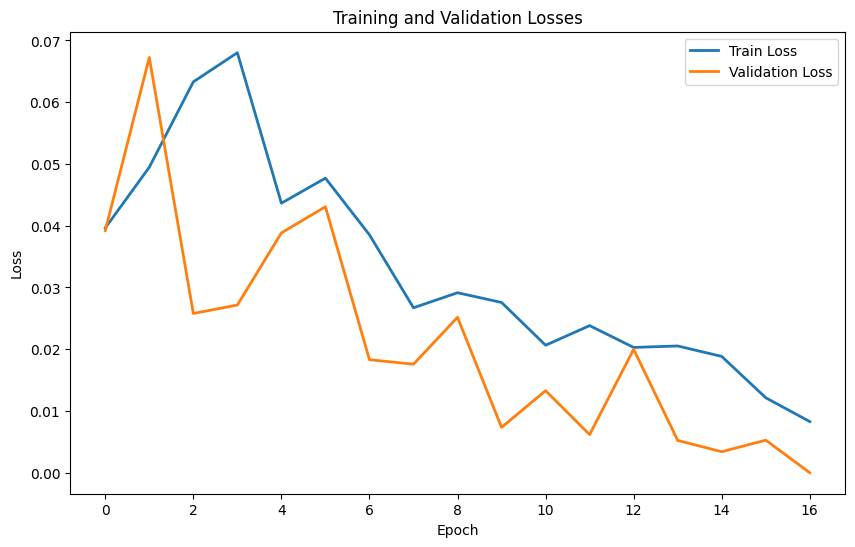

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedInceptionResnetV1(embedding_size=128).to(device)

model.load_state_dict(torch.load('face_embedding_model.pth'))
model.eval()

sample = val_triplet_dataset[18]
anchor_images, positive_images, negative_images = sample
anchor_images, positive_images, negative_images = (
    anchor_images.unsqueeze(0).to(device),
    positive_images.unsqueeze(0).to(device),
    negative_images.unsqueeze(0).to(device),
)

with torch.no_grad():
    anchor_embeddings = model(anchor_images)
    positive_embeddings = model(positive_images)
    negative_embeddings = model(negative_images)

distance_positive = torch.norm(anchor_embeddings - positive_embeddings, dim=1).item()
distance_negative = torch.norm(anchor_embeddings - negative_embeddings, dim=1).item()

print(f'Distance between Anchor and Positive: {distance_positive}')
print(f'Distance between Anchor and Negative: {distance_negative}')

Distance between Anchor and Positive: 0.5913325548171997
Distance between Anchor and Negative: 1.2166986465454102


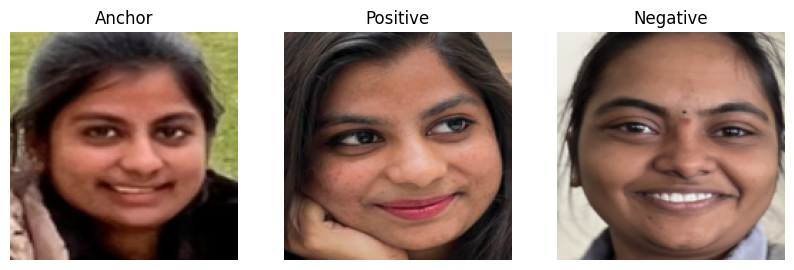

Distance between Anchor and Positive: 0.5913325548171997
Distance between Anchor and Negative: 1.2166986465454102


In [64]:
unnormalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])

unnormalized_anchor = unnormalize(anchor_images.squeeze()).permute(1, 2, 0).cpu().numpy()
unnormalized_positive = unnormalize(positive_images.squeeze()).permute(1, 2, 0).cpu().numpy()
unnormalized_negative = unnormalize(negative_images.squeeze()).permute(1, 2, 0).cpu().numpy()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].imshow(unnormalized_anchor)
axs[0].axis('off')
axs[0].set_title('Anchor')

axs[1].imshow(unnormalized_positive)
axs[1].axis('off')
axs[1].set_title('Positive')

axs[2].imshow(unnormalized_negative)
axs[2].axis('off')
axs[2].set_title('Negative')

plt.show()

print(f'Distance between Anchor and Positive: {distance_positive}')
print(f'Distance between Anchor and Negative: {distance_negative}')